# Fall Pervention - Data Analysis

>[Fall Pervention - Data Analysis](#scrollTo=-xh1Of4lk5V2)

>>[Getting Ready](#scrollTo=o8w5Kah4lic6)

>>>>[Importing the libraries](#scrollTo=wzlEwGQKk5m0)

>>>>[Uploading the ZIP file containing the patients data dirs:](#scrollTo=ehouBttelr-f)

>>>>[Extracting the ZIP file into ./data/](#scrollTo=uLDiWW7ZmAxp)

>>>>[Creating our Dataset using all patients data:](#scrollTo=RZWl3rQUmPXV)

>>[Data Exploration](#scrollTo=EPiOmgwip-4v)

>>>>[Splitting the Dataset](#scrollTo=T7PpCtlYpkZy)

>>>>[Data Pre-Processing Pipeline](#scrollTo=QBWfkXz3prUi)

>>>>[Boxplots of the sensors:](#scrollTo=txZ71RyyqJbx)

>>>>[Jointplots of conflicting positions](#scrollTo=9m7SBaCnrUxB)

>>>>[Separating the labels from the data](#scrollTo=ERO0JOWxuSQ3)

>>[Everyday I'm Modeling](#scrollTo=xNac6hGA8YsD)

>>>[First Take](#scrollTo=cnCP3rDjI01N)

>>>>[Convolutional Neural Network](#scrollTo=eqtJcGCF8Y-b)

>>>>[Recurrent Neural Network](#scrollTo=gsKIxcXr8udO)

>>>>[Random Forest](#scrollTo=veCRuGrz8yGb)

>>>[Second Take](#scrollTo=bdyx44AkJAAx)

>>>>[Convolutional Neural Network](#scrollTo=mrMTE3pcKXzn)

>>>[Conclusion](#scrollTo=LGdw3-sVOMdk)

>>[Store the Model](#scrollTo=L5YoE10oP0wW)



## Getting Ready

#### Importing the libraries
We'll use Matplotlib, Seaborn for our charts, Numpy, Pandas for the data and calculations, and Tensorflor/keras for the Neural Networks:

In [ ]:
from google.colab import files

import zipfile
import random
import copy
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier

from keras.layers import Conv1D, BatchNormalization, Dense, Flatten, Input, LSTM, Dropout
from keras.models import Sequential
import tensorflow as tf
import torch
import keras

#### Uploading the ZIP file containing the patients data dirs:

In [ ]:
uploadedData = files.upload()

Saving data.zip to data.zip


#### Extracting the ZIP file into ./data/

In [ ]:
filename = list(uploadedData)[0]
data_dir = "data/"

try:
    os.rmdir(data_dir)
except FileNotFoundError:
    pass

os.mkdir(data_dir)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

#### Creating our Dataset using all patients data:

For each patient dir and for each csv file in the dir, make one dataset containing all of the file's content

In [ ]:
def create_dataset(data_dir: str, rand: bool = False) -> pd.DataFrame:
    files_content_list = []
    
    dirs = list(os.listdir(data_dir))
    if rand:
        random.shuffle(dirs, )

    # For each Patient dir
    for dir in dirs:
        if os.path.isfile(os.path.join(data_dir, dir)):
            continue

        if dir == "__MACOSX":
            continue
            
        print(dir)
        # For each data file
        for file in os.listdir(os.path.join(data_dir, dir)):
            if not os.path.isfile(os.path.join(data_dir, dir, file)):
                continue

            file_content = pd.read_csv(os.path.join(data_dir, dir, file))
            files_content_list.append(file_content)
        
    if rand:
        random.shuffle(files_content_list)

    return pd.concat(files_content_list, axis=0, ignore_index=True)

In [ ]:
random.seed(0)
dataset = create_dataset(data_dir, True)

yinon
omer
yanai
hay
orad
almog
may
tomer
sapir
eden


## Data Exploration

Let's look at our data samples:

In [ ]:
print(dataset.shape)
print(dataset.head())

(6400, 12)
   Unnamed: 0  FFSR1  FFSR2  FFSR3  FFSR4  RFSR1  RFSR2  RFSR3  RFSR4  Weight  \
0           0   2377      0      0      0    656     73    343      0      60   
1           1   2400      0      0      0    656     74    356      0      60   
2           2   2407      0      0      0    657     80    361      0      60   
3           3   2494      0      0      0    668     75    371      0      60   
4           4   2519      0      0      0    671     77    386      0      60   

   Height  Label  
0     175      4  
1     175      4  
2     175      4  
3     175      4  
4     175      4  


We can see that our data sampled equally among the labels:

In [ ]:
print(dataset.Label.value_counts())

4    1280
0    1280
3    1280
2    1280
1    1280
Name: Label, dtype: int64


#### Splitting the Dataset

We will use 80% of the dataset for training, and 20% for testing.
We will NOT use shuffle, as we want to test "new" patients.

In [ ]:
random_state = 0
test_size = 0.2

train, test = train_test_split(dataset, test_size=test_size, shuffle=False)

print(train.shape, test.shape)

(5120, 12) (1280, 12)


In [ ]:
"""
train_download = train.copy()
train_download.drop(columns=train_download.columns[0], axis=1,  inplace=True)
train_download.drop("Weight", axis=1,  inplace=True)
train_download.drop("Height", axis=1,  inplace=True)
train_download.drop("Label", axis=1,  inplace=True)
train_download.to_csv("train.csv")
files.download("train.csv") 
"""

'\ntrain_download = train.copy()\ntrain_download.drop(columns=train_download.columns[0], axis=1,  inplace=True)\ntrain_download.drop("Weight", axis=1,  inplace=True)\ntrain_download.drop("Height", axis=1,  inplace=True)\ntrain_download.drop("Label", axis=1,  inplace=True)\ntrain_download.to_csv("train.csv")\nfiles.download("train.csv") \n'

#### Data Pre-Processing Pipeline

Simple Pre-processing:
We will remove the ID, Weight and Height columns.
Also, We will use Standard Scaler to normalize all of the features.

In [ ]:
class data_preparation():

  def __init__(self, training_data, new_data):
    self.new_dataset = new_data.copy()
    self.training_data_ref = training_data.copy()

    self.__remove_ids(self.training_data_ref)

  def __remove_ids(self, dataset):
      dataset.drop(columns=dataset.columns[0], axis=1,  inplace=True)
      dataset.drop("Weight", axis=1,  inplace=True)
      dataset.drop("Height", axis=1,  inplace=True)
      

  def __normalize(self):
    all_features = list(self.training_data_ref.columns)
    all_features.remove('Label')

    
    for feature in all_features:
        std_scaler = StandardScaler()
        std_scaler.fit(self.training_data_ref[[feature]])

        self.new_dataset[[feature]] = std_scaler.transform(self.new_dataset[[feature]])
    
    return self.new_dataset


  def prepare(self):
    self.__remove_ids(self.new_dataset)
    self.__normalize()

    return self.new_dataset

def preprare_data(training_data, new_data):
  data_prep = data_preparation(training_data, new_data)
  return data_prep.prepare()


Our data after the pre-processing:

In [ ]:
prep_train = preprare_data(train, train)
prep_test = preprare_data(train, test)

print(prep_train.shape, prep_test.shape)
prep_train.head()

(5120, 9) (1280, 9)


,FFSR1,FFSR2,FFSR3,FFSR4,RFSR1,RFSR2,RFSR3,RFSR4,Label
0,-0.722463,0.771245,-0.459352,-0.653086,-0.617738,0.550925,0.587753,0.585868,1
1,-0.722463,0.771245,-0.367503,-0.653086,-0.617738,0.550925,0.591043,0.593482,1
2,-0.722463,0.768714,-0.366191,-0.653086,-0.617738,0.550925,0.604204,0.593482,1
3,-0.722463,0.765551,-0.373407,-0.653086,-0.617738,0.547684,0.607495,0.589675,1
4,-0.722463,0.758591,-0.369471,-0.653086,-0.617738,0.547684,0.607495,0.589675,1


#### Boxplots of the sensors:

In [ ]:
def get_boxplots(data: pd.DataFrame) -> None:
    f, pl = plt.subplots(3, 2, figsize=(25, 15))

    all_features = list(data.columns)
    all_features.remove('Label')

    tmpdf0 = data[data.Label == 0]
    tmpdf1 = data[data.Label == 1]
    tmpdf2 = data[data.Label == 2]
    tmpdf3 = data[data.Label == 3]
    tmpdf4 = data[data.Label == 4]


    sns.boxplot(ax = pl[0][0], data=tmpdf0.loc[:,all_features])
    sns.boxplot(ax = pl[0][1], data=tmpdf1.loc[:,all_features])
    sns.boxplot(ax = pl[1][0], data=tmpdf2.loc[:,all_features])
    sns.boxplot(ax = pl[1][1], data=tmpdf3.loc[:,all_features])
    sns.boxplot(ax = pl[2][0], data=tmpdf4.loc[:,all_features])

    pl[0][0].set_title("Sensors values - Laying Center")
    pl[0][1].set_title("Sensors values - Laying Left")
    pl[1][0].set_title("Sensors values - Laying Right")
    pl[1][1].set_title("Sensors values - Alarm Left")
    pl[2][0].set_title("Sensors values - Alarm Right")

    f.tight_layout(pad=5.0)

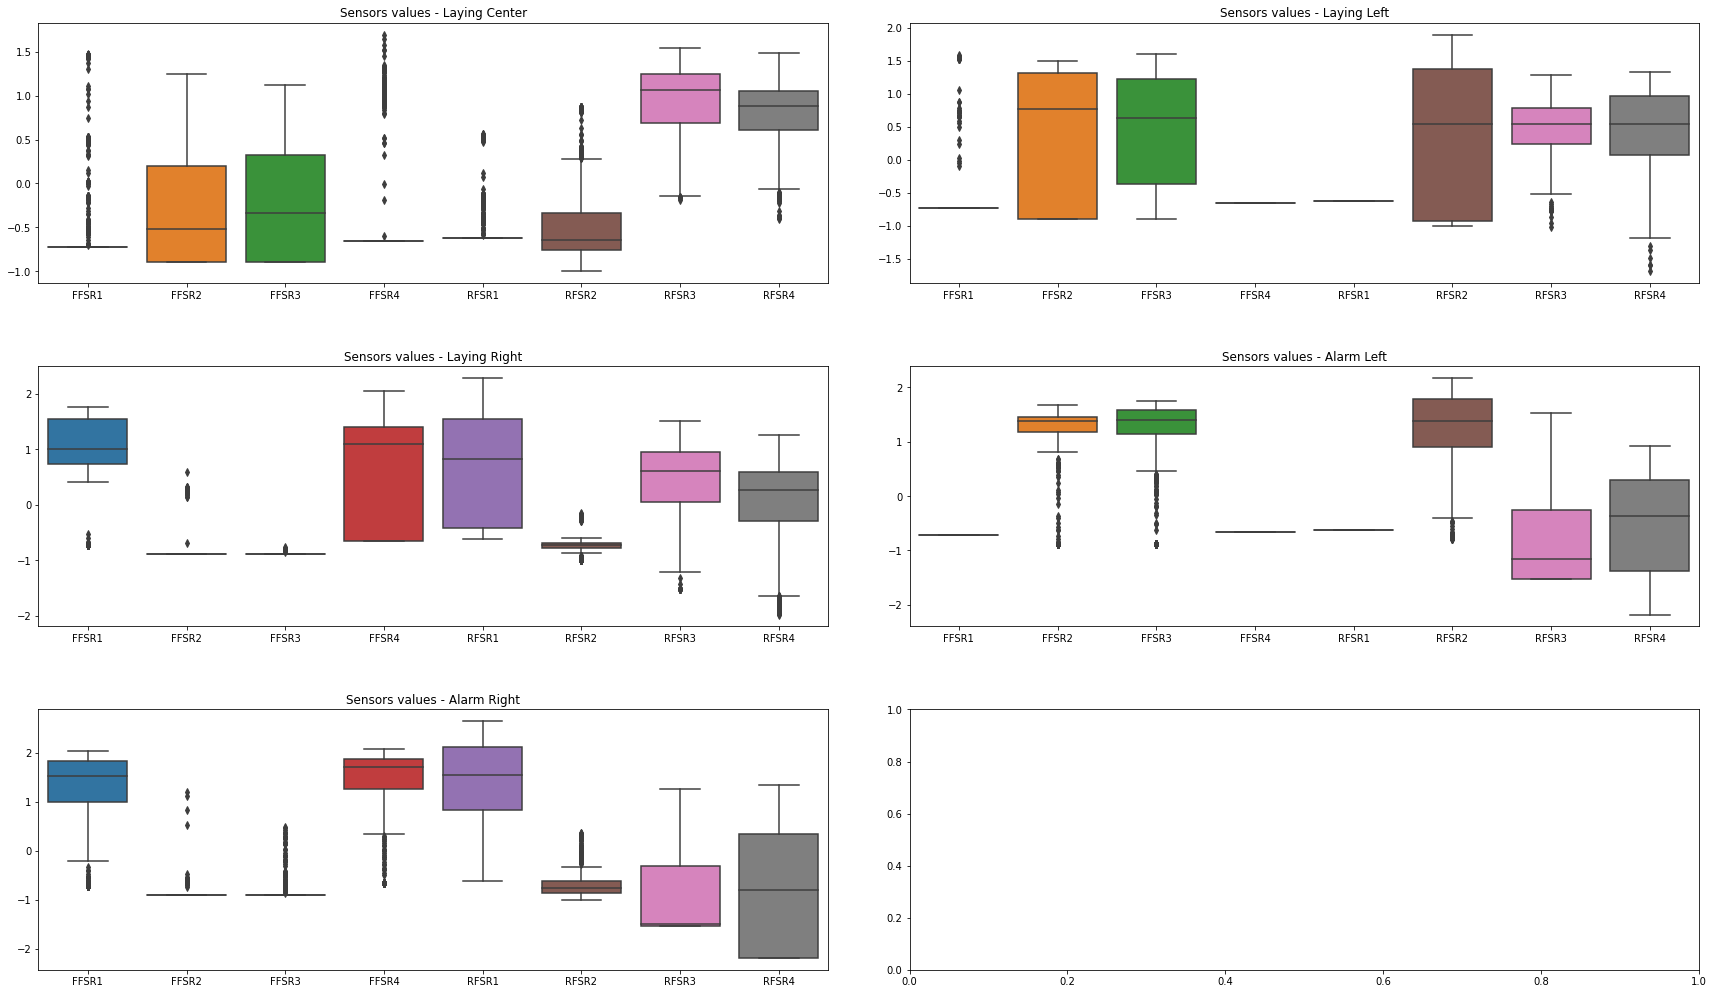

In [ ]:
get_boxplots(prep_train)

We can see that the sensors give unique values for each label (position) in average, thing that will help us later. 

#### Jointplots of conflicting positions

Text(0.5, 0.98, 'Left vs. Left Alarm')

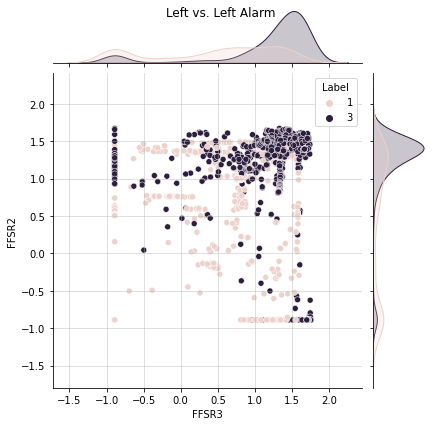

In [ ]:
sns.color_palette("colorblind")
g = sns.jointplot(x="FFSR3", y="FFSR2", data=prep_train[(prep_train.Label == 1) | (prep_train.Label == 3)], hue='Label')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("Left vs. Left Alarm")

Text(0.5, 0.98, 'Right vs. Right Alarm')

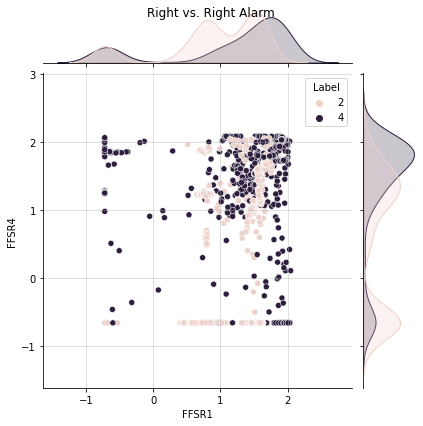

In [ ]:
g = sns.jointplot(x="FFSR1", y="FFSR4", data=prep_train[(prep_train.Label == 2) | (prep_train.Label == 4)], hue='Label')
_ = g.ax_joint.grid(alpha=0.5)
g.fig.suptitle("Right vs. Right Alarm")

Here we also can see unique values in the sensors that located on the sides of the bed. <br>
Problem is, There are coflicts in the values, and that might lead to lower accuracies. <br>
Let's try the look at the data from different angle:


In [ ]:
def plot3d(df, colX:str, colY:str, colZ:str, title:str, predictions=None):
  fig = plt.figure(figsize=(20, 7))
  axes = [fig.add_subplot(1, 3, i+1, projection='3d') for i in range(3)]

  palette = sns.color_palette("hls", 2)

  for i,ax in enumerate(axes):
    if predictions is not None:
      ax.scatter3D(df[colX], df[colY], predictions, color=palette[1], s=3)
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1, 
                   alpha=0.35, depthshade=False)
    else:
      ax.scatter3D(df[colX], df[colY], df[colZ], color=palette[0], s=1)

    ax.set_xlabel(colX)
    ax.set_ylabel(colY)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    ax.view_init(elev=5., azim=45*i)
  
  axes[0].set_zlabel("\n" + colZ, linespacing=3)

  plt.suptitle(title, fontsize=32)
  plt.tight_layout()
  plt.show()

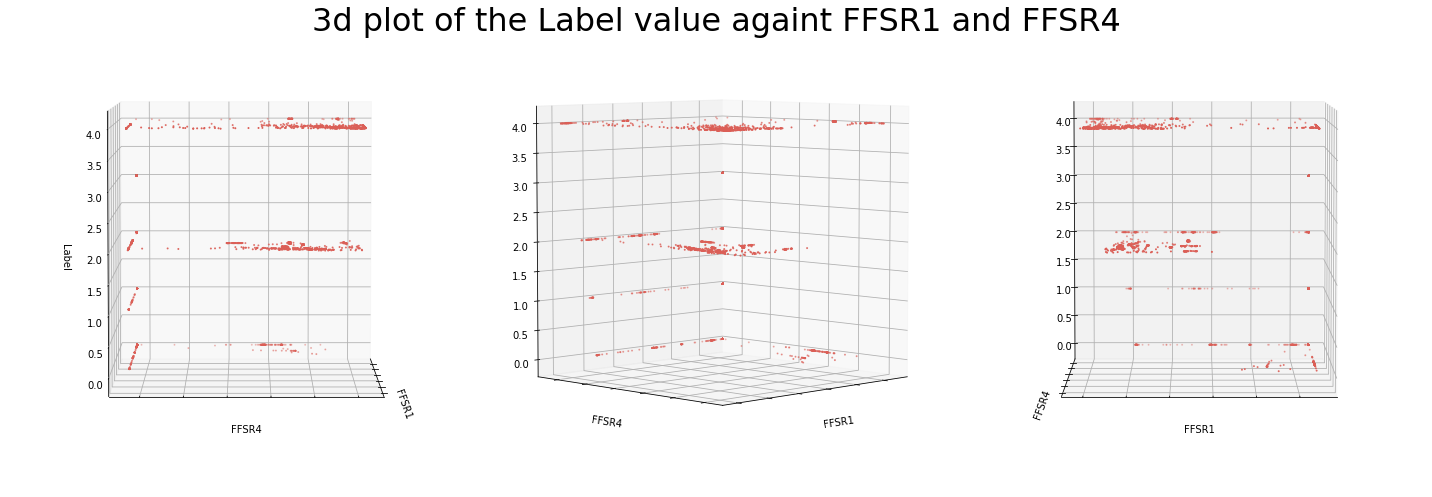

In [ ]:
plot3d(prep_train, "FFSR1", "FFSR4", "Label", "3d plot of the Label value againt FFSR1 and FFSR4")

#### Separating the labels from the data

For Non-Sequential models:

In [ ]:
all_features = list(prep_train.columns)
all_features.remove('Label')

X_train = prep_train.loc[:,all_features]
y_train = prep_train["Label"]

X_test = prep_test.loc[:,all_features]
y_test = prep_test["Label"]

For Sequential models:

In [ ]:
SEQ_LEN = 4

def get_time_series_df(X, y, length = SEQ_LEN):
    ts_X, ts_y = [], []
    for l in range(0, len(X) - length):
        ts_X.append(X[l:l + length])
        ts_y.append(y[l])

    return np.array(ts_X), np.array(ts_y)

In [ ]:
X_train_sequence, y_train_sequence = get_time_series_df(prep_train.loc[:,all_features].values, prep_train.Label.values)
X_test_sequence, y_test_sequence = get_time_series_df(prep_test.loc[:,all_features].values, prep_test.Label.values)

## Everyday I'm Modeling

### First Take

In the first take, we would like to get an idea of which model will be optimal forr our data.

#### Convolutional Neural Network

In [ ]:
model = Sequential()
model.add(Input((SEQ_LEN, len(all_features), )))
model.add(Conv1D(filters=128, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model.summary()

High level diagram of the network:

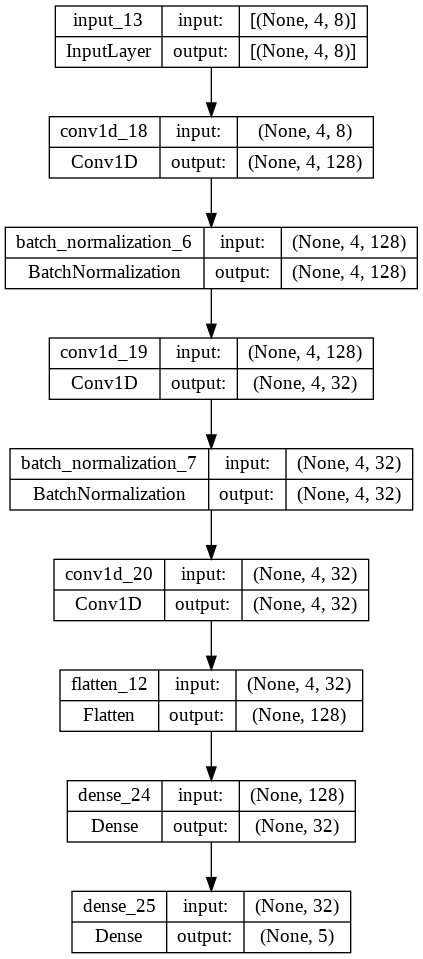

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

Let's train our CNN:

In [ ]:
hist = model.fit(X_train_sequence, y_train_sequence, batch_size=128, epochs=24, verbose=1, validation_data=(X_train_sequence, y_train_sequence))

Epoch 1/24
40/40 [==============================] - 2s 19ms/step - loss: 0.6141 - accuracy: 0.7662 - val_loss: 0.5567 - val_accuracy: 0.8395
Epoch 2/24
40/40 [==============================] - 0s 12ms/step - loss: 0.3371 - accuracy: 0.8782 - val_loss: 0.4415 - val_accuracy: 0.8616
Epoch 3/24
40/40 [==============================] - 1s 13ms/step - loss: 0.2765 - accuracy: 0.9023 - val_loss: 0.3505 - val_accuracy: 0.8937
Epoch 4/24
40/40 [==============================] - 1s 18ms/step - loss: 0.2480 - accuracy: 0.9163 - val_loss: 0.3036 - val_accuracy: 0.8804
Epoch 5/24
40/40 [==============================] - 1s 13ms/step - loss: 0.2276 - accuracy: 0.9167 - val_loss: 0.2575 - val_accuracy: 0.9017
Epoch 6/24
40/40 [==============================] - 1s 13ms/step - loss: 0.2054 - accuracy: 0.9290 - val_loss: 0.2196 - val_accuracy: 0.9244
Epoch 7/24
40/40 [==============================] - 1s 14ms/step - loss: 0.1866 - accuracy: 0.9376 - val_loss: 0.2079 - val_accuracy: 0.9351
Epoch 8/24
40

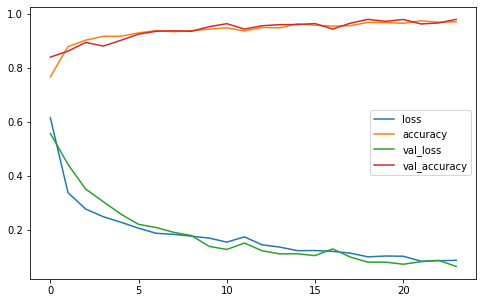

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

40/40 [==============================] - 0s 3ms/step
Train Accuracy: 97.9%, Test Accuracy: 68.3%


Not good!
Surprisingly, we have got relatively poor Test Accuracy.

Let's see where the model was wrong:

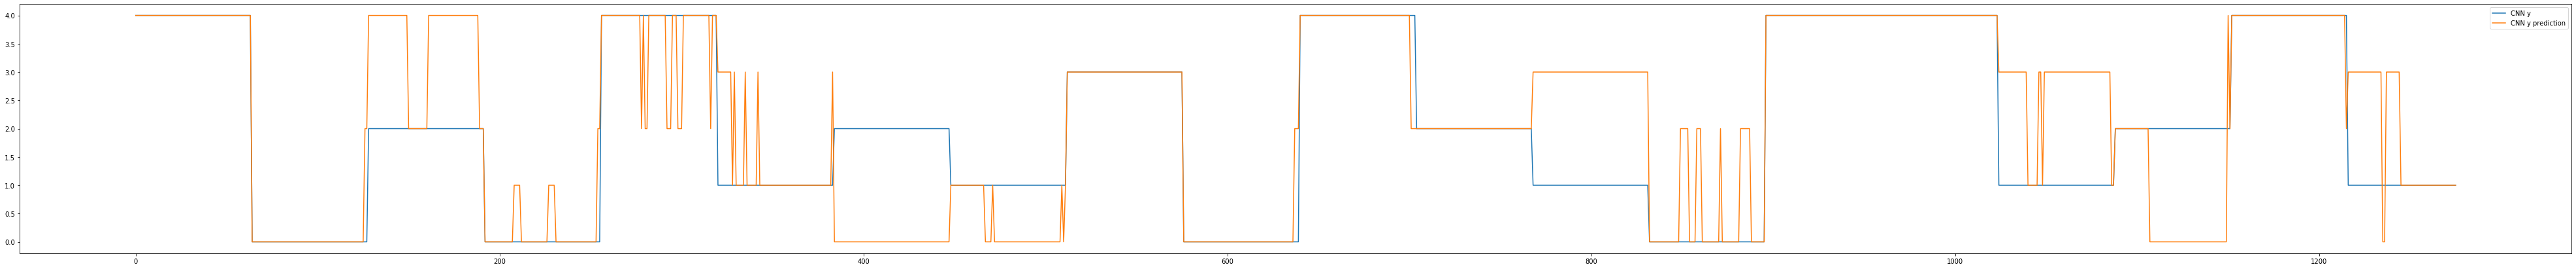

In [ ]:
ds = pd.DataFrame()

ds["CNN y"] = y_test_sequence
ds["CNN y prediction"] = y_test_pred

ds.plot(figsize=(70, 7))

From the data exploration above, it can be seen that the sensors gives close values for the positions: Back, Left and Right laying (Without alert).
Let's try to "merge" them into one label:

In [ ]:
a,b,c,d,e,f = 0,0,0,0,0,0
for i in range(len(y_test_pred)):
    if y_test_sequence[i] == 3:
        if y_test_pred[i] == 3:
            a += 1
        b += 1

    if y_test_sequence[i] == 4:
        if y_test_pred[i] == 4:
            c += 1
        d += 1

    if y_test_sequence[i] in [0,1,2]:
        if y_test_pred[i] in [0,1,2]:
            e += 1
        f += 1
        
print(a/b, c/d, e/f)

1.0 0.9635416666666666 0.7475845410628019


Amazing Results!

#### Recurrent Neural Network

In [ ]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(SEQ_LEN, len(all_features)), activation="relu"))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.summary()

Let's train our LSTM RNN:

In [ ]:
model.fit(X_train_sequence, y_train_sequence, batch_size=128, epochs=24)

Epoch 1/24


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 2s 10ms/step - loss: 1.5425 - accuracy: 0.3307
Epoch 2/24
10/10 [==============================] - 0s 10ms/step - loss: 1.3642 - accuracy: 0.5653
Epoch 3/24
10/10 [==============================] - 0s 9ms/step - loss: 1.1671 - accuracy: 0.6271
Epoch 4/24
10/10 [==============================] - 0s 10ms/step - loss: 0.9685 - accuracy: 0.6833
Epoch 5/24
10/10 [==============================] - 0s 10ms/step - loss: 0.7550 - accuracy: 0.7224
Epoch 6/24
10/10 [==============================] - 0s 10ms/step - loss: 0.6257 - accuracy: 0.7334
Epoch 7/24
10/10 [==============================] - 0s 9ms/step - loss: 0.5593 - accuracy: 0.7568
Epoch 8/24
10/10 [==============================] - 0s 9ms/step - loss: 0.4998 - accuracy: 0.7803
Epoch 9/24
10/10 [==============================] - 0s 11ms/step - loss: 0.4583 - accuracy: 0.8163
Epoch 10/24
10/10 [==============================] - 0s 10ms/step - loss: 0.4330 - accuracy: 0.8241
Epoch 11/24
10/10 [====

Let's test out RNN:

In [ ]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

10/10 [==============================] - 0s 3ms/step
Train Accuracy: 94.2%, Test Accuracy: 64.3%


Slightly better than the CNN. but still - could be better...

#### Random Forest

Let's try Random Forest too, as an example of non sequential model:

In [ ]:
h = RandomForestClassifier(n_estimators=100, max_leaf_nodes=12)
h.fit(X_train, y_train)

trainAcc = np.sum(h.predict(X_train) == y_train) * 100 / len(y_train)
testAcc = np.sum(h.predict(X_test) == y_test) * 100 / len(y_test)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Train Accuracy: 92.9%, Test Accuracy: 60.1%


Same problem as the above models... need new approach!

### Second Take

Lets use the conclusion from the First Take of the modeling, and merge the non-alarm labels:

In [ ]:
class data_preparation():

  def __init__(self, training_data, new_data):
    self.new_dataset = new_data.copy()
    self.training_data_ref = training_data.copy()

    self.__remove_ids(self.training_data_ref)
    self.__merge_labels(self.training_data_ref)

  def __merge_labels(self, dataset):
      dataset.loc[dataset['Label'] == 0, 'Label'] = 0
      dataset.loc[dataset['Label'] == 1, 'Label'] = 0
      dataset.loc[dataset['Label'] == 2, 'Label'] = 0
      dataset.loc[dataset['Label'] == 3, 'Label'] = 1
      dataset.loc[dataset['Label'] == 4, 'Label'] = 2

  def __remove_ids(self, dataset):
      dataset.drop(columns=dataset.columns[0], axis=1,  inplace=True)
      dataset.drop("Weight", axis=1,  inplace=True)
      dataset.drop("Height", axis=1,  inplace=True)
      

  def __normalize(self):
    all_features = list(self.training_data_ref.columns)
    all_features.remove('Label')

    
    for feature in all_features:
        std_scaler = StandardScaler()
        std_scaler.fit(self.training_data_ref[[feature]])

        self.new_dataset[[feature]] = std_scaler.transform(self.new_dataset[[feature]])
    
    return self.new_dataset


  def prepare(self):
    self.__merge_labels(self.new_dataset)
    self.__remove_ids(self.new_dataset)
    self.__normalize()

    return self.new_dataset

def preprare_data(training_data, new_data):
  data_prep = data_preparation(training_data, new_data)
  return data_prep.prepare()

In [ ]:
prep_train = preprare_data(train, train)
prep_test = preprare_data(train, test)

all_features = list(prep_train.columns)
all_features.remove('Label')

X_train_sequence, y_train_sequence = get_time_series_df(prep_train.loc[:,all_features].values, prep_train.Label.values)
X_test_sequence, y_test_sequence = get_time_series_df(prep_test.loc[:,all_features].values, prep_test.Label.values)

### Convolutional Neural Network

#### Hyperparameters Tuninig

Let's start with CV for the Epochs and the batches size and get an idea of there values:

In [ ]:
def build_cnn():
    model = Sequential()
    model.add(Input((SEQ_LEN, len(all_features), )))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

# model.summary()

epochs = list(range(8, 40, 8))
batches = list(range(10, 500, 50))

model_CV = KerasClassifier(build_fn=build_cnn, verbose=1)
parameters = {'epochs':epochs, 'batch_size':batches}
grid = GridSearchCV(estimator=model_CV, param_grid=parameters, n_jobs=-1, cv=2)
grid_result = grid.fit(X_train_sequence, y_train_sequence)

<ipython-input-131-a3b9a4901008>:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_CV = KerasClassifier(build_fn=build_cnn, verbose=1)


Epoch 1/24
12/12 [==============================] - 1s 15ms/step - loss: 0.5607 - accuracy: 0.8055
Epoch 2/24
12/12 [==============================] - 0s 14ms/step - loss: 0.2377 - accuracy: 0.9048
Epoch 3/24
12/12 [==============================] - 0s 15ms/step - loss: 0.1664 - accuracy: 0.9371
Epoch 4/24
12/12 [==============================] - 0s 15ms/step - loss: 0.1328 - accuracy: 0.9498
Epoch 5/24
12/12 [==============================] - 0s 15ms/step - loss: 0.1108 - accuracy: 0.9601
Epoch 6/24
12/12 [==============================] - 0s 17ms/step - loss: 0.1005 - accuracy: 0.9621
Epoch 7/24
12/12 [==============================] - 0s 15ms/step - loss: 0.0955 - accuracy: 0.9679
Epoch 8/24
12/12 [==============================] - 0s 15ms/step - loss: 0.0803 - accuracy: 0.9724
Epoch 9/24
12/12 [==============================] - 0s 15ms/step - loss: 0.0689 - accuracy: 0.9754
Epoch 10/24
12/12 [==============================] - 0s 16ms/step - loss: 0.0576 - accuracy: 0.9812
Epoch 11/

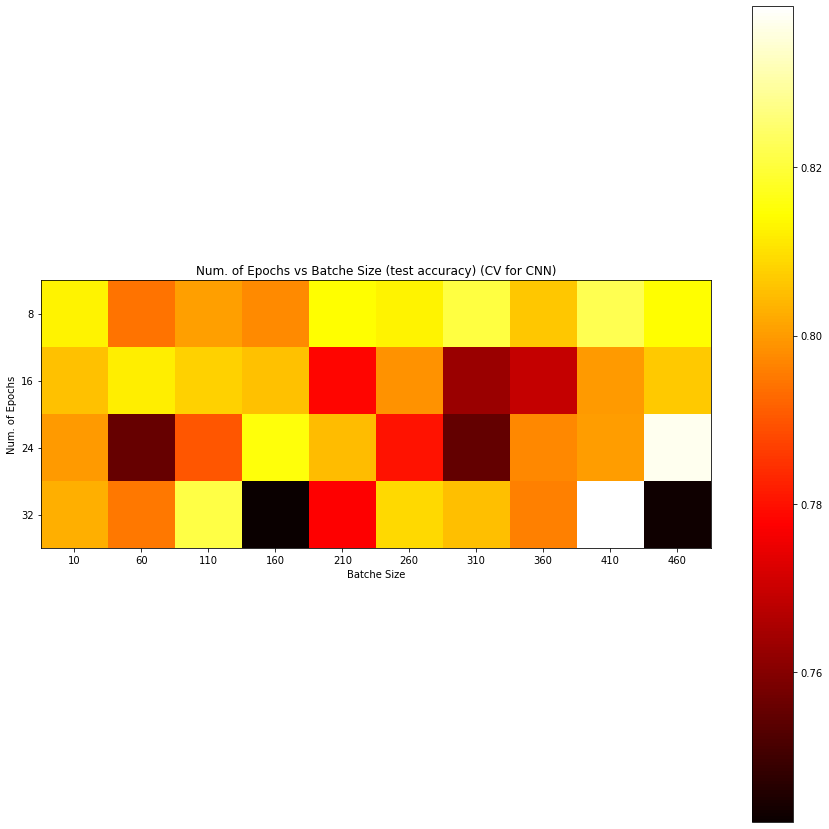

In [ ]:
scores = grid.cv_results_['mean_test_score'].reshape(len(epochs),len(batches))

plt.figure(figsize=(15, 15))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('Batche Size')
plt.ylabel('Num. of Epochs')
plt.colorbar()
plt.xticks(np.arange(len(batches)), batches)
plt.yticks(np.arange(len(epochs)), epochs)
plt.title('Num. of Epochs vs Batche Size (test accuracy) (CV for CNN)')
plt.show()


...

In [ ]:
def build_cnn():
    model = Sequential()
    model.add(Input((SEQ_LEN, len(all_features), )))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(3))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model


Epoch 1/64
13/13 [==============================] - 1s 6ms/step - loss: 0.8027 - accuracy: 0.7873
Epoch 2/64
13/13 [==============================] - 0s 6ms/step - loss: 0.4306 - accuracy: 0.8497
Epoch 3/64
13/13 [==============================] - 0s 6ms/step - loss: 0.3180 - accuracy: 0.8753
Epoch 4/64
13/13 [==============================] - 0s 5ms/step - loss: 0.2732 - accuracy: 0.8943
Epoch 5/64
13/13 [==============================] - 0s 5ms/step - loss: 0.2460 - accuracy: 0.9019
Epoch 6/64
13/13 [==============================] - 0s 5ms/step - loss: 0.2279 - accuracy: 0.9046
Epoch 7/64
13/13 [==============================] - 0s 6ms/step - loss: 0.2121 - accuracy: 0.9111
Epoch 8/64
13/13 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.9136
Epoch 9/64
13/13 [==============================] - 0s 6ms/step - loss: 0.1890 - accuracy: 0.9210
Epoch 10/64
13/13 [==============================] - 0s 6ms/step - loss: 0.1773 - accuracy: 0.9240
Epoch 11/64
13/13 [

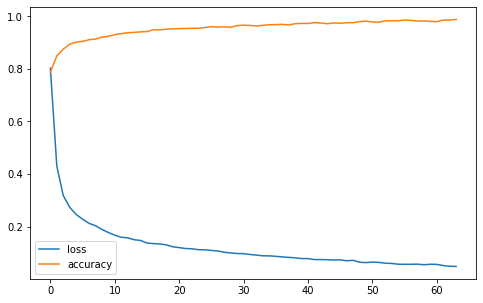

40/40 [==============================] - 0s 2ms/step
Train Accuracy: 98.5%, Test Accuracy: 87.1%


In [ ]:
model = build_cnn()
batch_size = 423
epochs = 64

hist = model.fit(X_train_sequence, y_train_sequence, batch_size=batch_size, epochs=epochs, verbose=True)
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

### Conclusion

As we suspected, the CNN gives the best predictions!

## Store the Model

In [ ]:
model.save("fp_model.h5")

Download the model:

In [ ]:
files.download('fp_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Little sanity check:

In [ ]:
uploadedData = files.upload()
model_name = list(uploadedData)[0]

loaded_model = tf.keras.models.load_model(model_name)

IndexError: ignored

In [ ]:
probability_model = tf.keras.Sequential([loaded_model, tf.keras.layers.Softmax()])

y_train_pred = probability_model.predict(X_train_sequence)
y_train_pred = [np.argmax(i) for i in y_train_pred]

y_test_pred = probability_model.predict(X_test_sequence)
y_test_pred =  [np.argmax(i) for i in y_test_pred]

trainAcc = np.sum(y_train_pred == y_train_sequence) * 100 / len(y_train_sequence)
testAcc = np.sum(y_test_pred == y_test_sequence) * 100 / len(y_test_sequence)

print("Train Accuracy: {:.1f}%, Test Accuracy: {:.1f}%".format(trainAcc, testAcc))

Perfect!